In [1]:
from ortools.linear_solver import pywraplp

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from itertools import combinations, permutations
import time

In [47]:
number_tickets = 10
seating_rows = 30
seating_columns = 30
number_seats = seating_rows * seating_columns
seat_depth = 0.5
seat_depth_gap = 0.2
seat_width = 0.5
seat_width_gap = 0.2

In [48]:
x_seats = np.array( [ (i % seating_columns) * (seat_width + seat_width_gap) + (seat_width / 2) for i in range(number_seats) ] )

In [49]:
y_seats = np.array( [ (i // seating_columns) * (seat_depth + seat_depth_gap) + (seat_depth / 2) for i in range(number_seats) ] )

In [50]:
#ticket_size = np.random.randint(low =1, high = 10, size = number_tickets)
ticket_size = np.ones(number_tickets)

In [51]:
ticket_size

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [52]:
48%7

6

In [53]:
def main():
    # Data
    
        
    
    # Solver
    # Create the mip solver with the CBC backend.
    solver = pywraplp.Solver.CreateSolver('assignment_mip', 'CBC')


    # Variables
    # x[i, j] is an array of 0-1 variables, which will be 1
    # if worker i is assigned to task j.
    #individual seats
    x = {}
    for i in range(number_seats):
        x[i] = solver.IntVar(0, 1, '')
    #couple seats
    y = {}
    for i in range(number_seats):
        y[i] = solver.IntVar(0, 1, '')

    # Constraints
    # Each ticekt is assigned to only one seat max
    
    #distance constraint
    
    for a, b in combinations(range(number_seats), 2):
        if (x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2 < 4:
            solver.Add(solver.Sum([ x[a] , x[b] ]) <= 1 )
            solver.Add(solver.Sum([ x[a] , y[b] ]) <= 1 )
            solver.Add(solver.Sum([ y[a] , x[b] ]) <= 1 )
            solver.Add(solver.Sum([ y[a] , y[b] ]) <= 1 )
        if a != number_seats - 1 and b != number_seats - 1 :
            if (x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2 >= 4 and (x_seats[a + 1] - x_seats[b])**2 + (y_seats[a + 1] - y_seats[b])**2 < 4 and a%seating_columns != seating_columns - 1:
                solver.Add(solver.Sum([ y[a] , y[b] ]) <= 1 )
                solver.Add(solver.Sum([ y[a] , x[b] ]) <= 1 )
                #solver.Add(solver.Sum([ x[a] , y[b] ]) <= 1 )
            if (x_seats[a] - x_seats[b])**2 + (y_seats[a] - y_seats[b])**2 >= 4 and (x_seats[a] - x_seats[b + 1])**2 + (y_seats[a] - y_seats[b + 1])**2 < 4 and b%seating_columns != seating_columns - 1:
                solver.Add(solver.Sum([ y[a] , y[b] ]) <= 1 )
                solver.Add(solver.Sum([ x[a] , y[b] ]) <= 1 )
                #solver.Add(solver.Sum([ y[a] , x[b] ]) <= 1 )
        
        
            
    # y cannot be last columns
    for i in range(1,seating_rows+1):
        solver.Add( y[i*seating_columns - 1] == 0 )
    
    # both y and x cannot be 1 at same seat
    for i in range(number_seats):
        solver.Add(solver.Sum([ y[i] , x[i] ]) <= 1 )
    
    # Objective
    objective_terms = []
    for i in range(number_seats):
        objective_terms.append(x[i])
    for i in range(number_seats):
        objective_terms.append(2*y[i])
    solver.Maximize(solver.Sum(objective_terms))

    # Solve
    status = solver.Solve()
    
    #sol_matrix
    soln_matrix_x = np.zeros((seating_rows, seating_columns))
    soln_matrix_y = np.zeros((seating_rows, seating_columns))
    soln_matrix = np.zeros((seating_rows, seating_columns))
    # Print solution.
    if status == pywraplp.Solver.OPTIMAL or status == pywraplp.Solver.FEASIBLE:
        print('Total cost = ', solver.Objective().Value(), '\n')
        for i in range(seating_columns):
            for j in range(seating_rows):
                # Test if x[i,j] is 1 (with tolerance for floating point arithmetic).
                if x[i + j * seating_columns].solution_value() > 0.5:
                    #print('Worker %d assigned to task %d.  Cost = %d' %
                          #(i, j, costs[i][j]))
                        print(j,i)
                        soln_matrix_x[j,i] = 1# creating and returning the solution in grid / matrix form
                        soln_matrix[j,i] = 1
                if y[i + j * seating_columns].solution_value() > 0.5:
                    soln_matrix_y[j,i] = 1
                    soln_matrix[j,i] = 2
        return(soln_matrix, soln_matrix_x, soln_matrix_y)
    else:
        return status


In [54]:
t1 = time.time()
soln, soln_x, soln_y = main()
t2 = time.time()
t2-t1

Total cost =  160.0 



542.980940580368

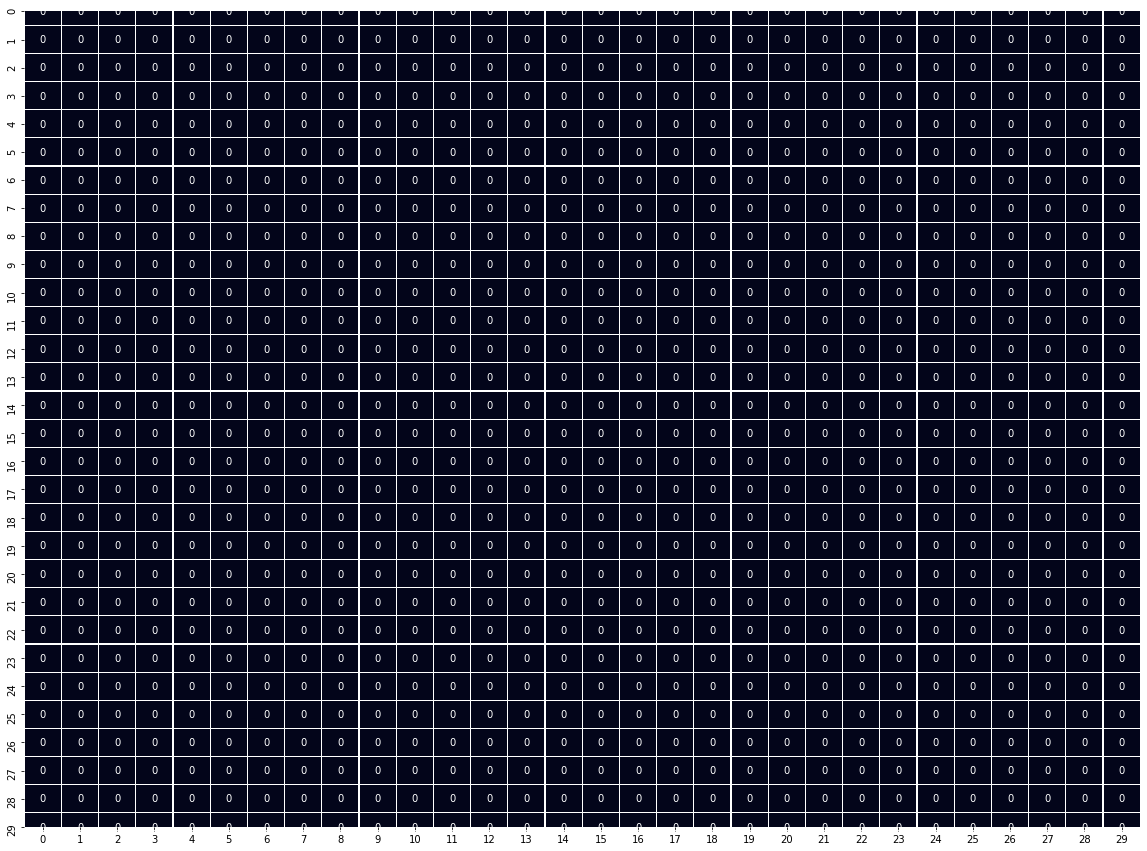

In [55]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(soln_x, linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

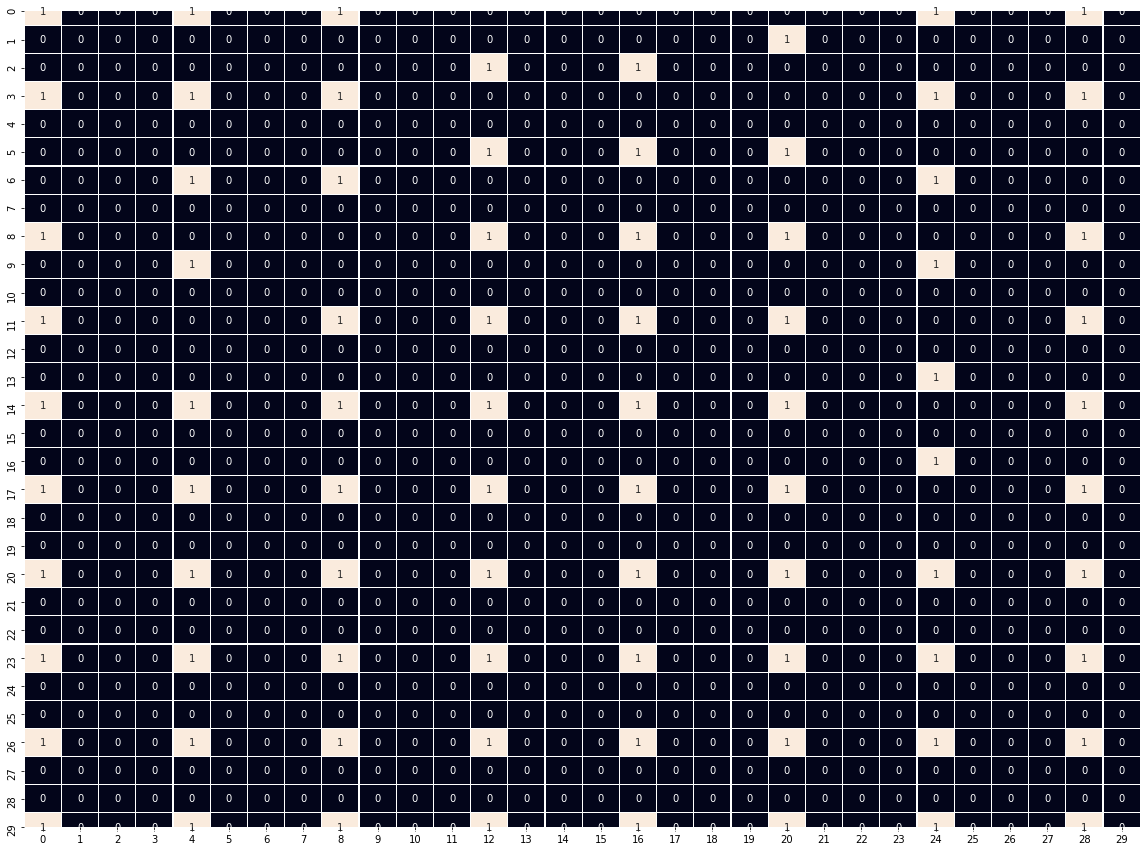

In [56]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(soln_y, linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)

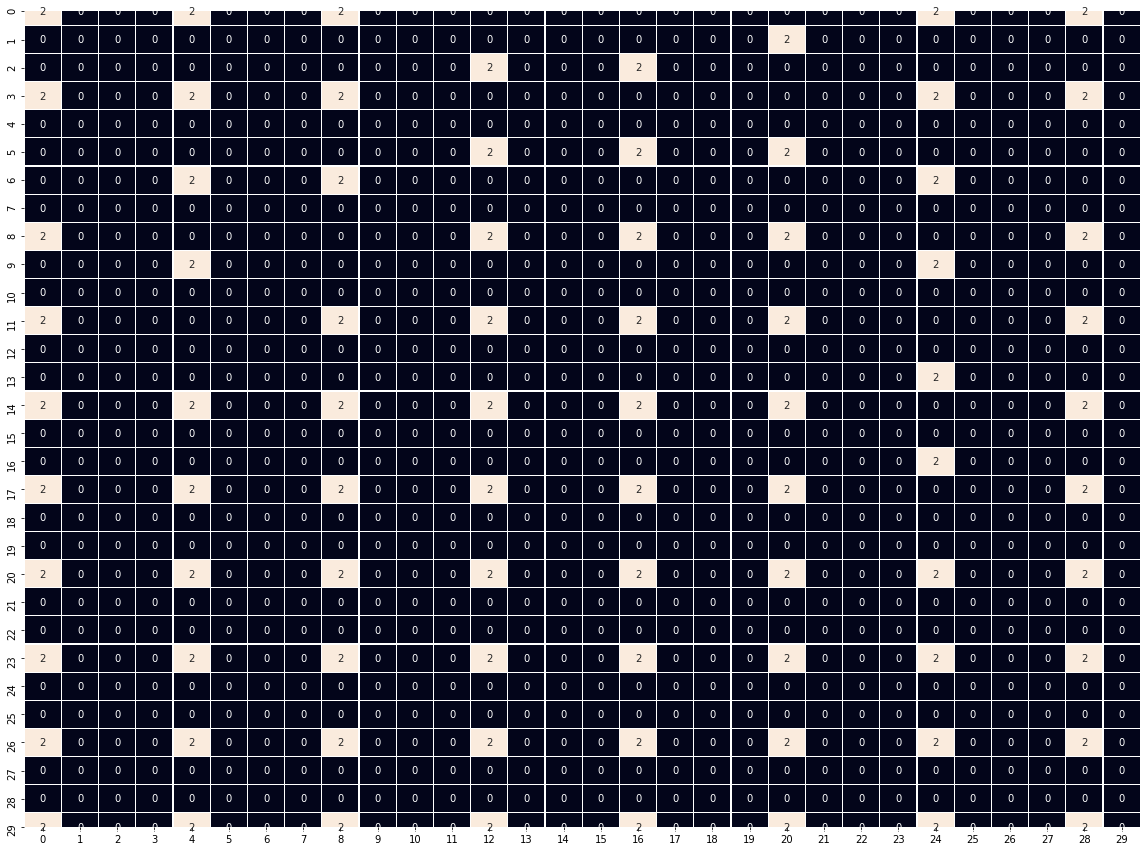

In [57]:
fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(soln, linecolor = 'white', linewidths = 0.1, annot = True, ax = ax, cbar =False)